# Generic case

In this tutorial, we show how to start with a generic scRNA-seq dataset with multiple cell types. To demonstrate the accuraty of `TOMAS`, we use a simulated dataset with ground truth of total-mRNA ratios between cell types.

In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import tomas as tm

load and analyze data with `scanpy`

Download the file `adata_mc.h5ad` from our [repo](https://github.com/QiuyuLian/TOMAS/blob/main/examples/simulated_data/adata_mc.h5ad).

In [2]:
adata = sc.read_h5ad('examples/simulated_data/adata_mc.h5ad')

## Computational doublet detection

Load putative doublets detected by computational doublet detection methods. Here we use `R` package [DoubletCollection](https://github.com/xnnba1984/DoubletCollection), which integrates multiple computational doublet-detection methods, for doublet detection. The benchmarking of different doublet detection methods and execution of `DoubletCollection` package could see Dobulet Detection [tutorial](https://github.com/QiuyuLian/TOMAS/blob/main/examples/simulated_data/doublet-detection.R).

In [3]:
dbl_pred = pd.read_csv('examples/simulated_data/dbl_pred_DoubletFinder.txt',header=None,index_col=None)
dbl_pred.head(3)

,0
0,d_0
1,d_7
2,d_10


In [4]:
adata.obs['droplet_type'] = 'Homotypic'
adata.obs.loc[np.ravel(dbl_pred),'droplet_type'] = 'Heterotypic'

Clutering putative singlets to identify cell types following the [clutering tutorial](https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html) of `scanpy`. We recommand not performing global normalization step.

## Homotypic droplet population identification

In [5]:
sc.settings.verbosity = 3            
sc.settings.set_figure_params(dpi=60, facecolor='white')

In [6]:
adata_psgl = adata[adata.obs['droplet_type']=='Homotypic'].copy()

adata_psgl.obs['n_counts'] = np.ravel(adata_psgl.X.sum(1))
sc.pp.filter_cells(adata_psgl, min_genes=1)
sc.pp.filter_genes(adata_psgl, min_cells=1)

sc.pp.log1p(adata_psgl)
sc.pp.highly_variable_genes(adata_psgl, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata_psgl.raw = adata_psgl
adata_psgl = adata_psgl[:, adata_psgl.var.highly_variable]
sc.pp.regress_out(adata_psgl, ['n_counts']) ##
sc.pp.scale(adata_psgl, max_value=10)
sc.tl.pca(adata_psgl, svd_solver='arpack')
sc.pp.neighbors(adata_psgl, n_neighbors=10, n_pcs=40)


filtered out 2886 genes that are detected in less than 1 cells
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
regressing out ['n_counts']
    sparse input is densified and may lead to high memory use
/home/qy/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1207: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.obs` of view, copying.
... storing 'droplet_type' as categorical
    finished (0:00:12)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:10)


computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:05)


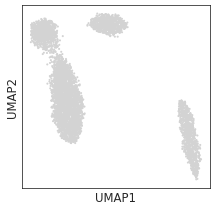

In [7]:
sc.tl.umap(adata_psgl)
sc.pl.umap(adata_psgl)


running Leiden clustering
    finished: found 4 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


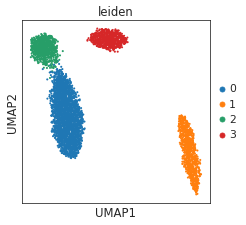

In [8]:
sc.tl.leiden(adata_psgl, resolution=0.1)
sc.pl.umap(adata_psgl, color=['leiden'])

(optional) Annotate cell clusters with domain knowledge of cell-type-specific transcriptomic markers. This step is optional. `TOMAS` could aslo be applied to infer total-mRNA ratioes between identified cell clusters.

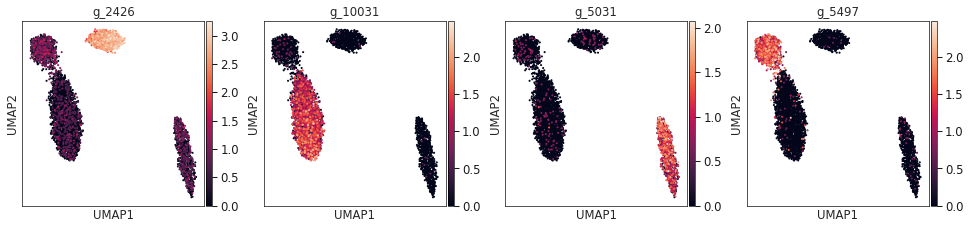

In [9]:
sc.pl.umap(adata_psgl, color=['g_2426','g_10031','g_5031','g_5497'],ncols=5)


If we could have good clustering results and could know marker genes of constitutive cell types, we could assign cell type labels to each identified cluster.

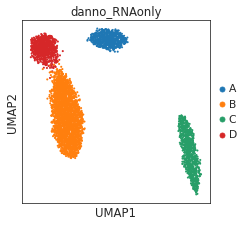

In [10]:
ct_mapper = {}
ct_mapper['3']='A'   # g_2426  marker of cell type A
ct_mapper['0']='B'   # g_10031 marker of cell type B
ct_mapper['1']='C'   # g_5031  marker of cell type C
ct_mapper['2']='D'   # g_5497  marker of cell type D

adata_psgl.obs['danno_RNAonly'] = pd.Categorical([ct_mapper[g] for g in adata_psgl.obs['leiden']],
                                                               categories=ct_mapper.values())

sc.pl.umap(adata_psgl, color=['danno_RNAonly'])

**Key**: save identified cell cluters/types as mandatory inputs for `TOMAS`

In [11]:
adata.obs['danno_RNAonly'] = 'unknown'
adata.obs.loc[adata_psgl.obs_names,'danno_RNAonly'] = adata_psgl.obs['danno_RNAonly'].values


## Hetero-doublets identification and refinement 

Detect genes specifically highly expressed in each cell type. 

In [12]:
sc.tl.rank_genes_groups(adata_psgl, 'danno_RNAonly', method='wilcoxon')
degene_sorted = tm.auxi.extract_specific_genes(adata_psgl, 'danno_RNAonly')


ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:03)


Identified heterotypic doublets expressing specific genes of both component cell types. 

If you don't want display the process one by one, you could run the code below to detect all kinds of heterotypic doublets one time:

Detect doublets composed by cell type A and B.


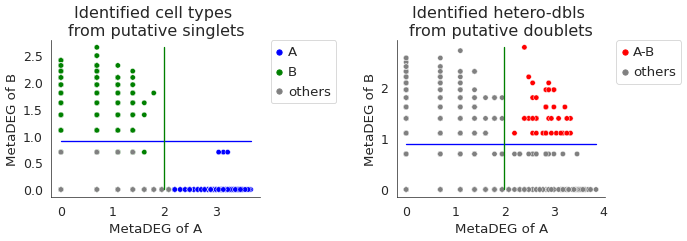

44 putative heterotypic doublets detected.
Detect doublets composed by cell type A and C.


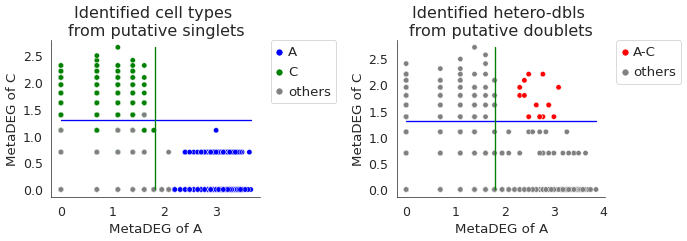

15 putative heterotypic doublets detected.
Detect doublets composed by cell type A and D.


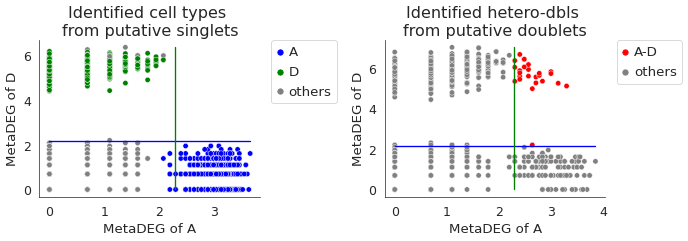

26 putative heterotypic doublets detected.
Detect doublets composed by cell type B and C.


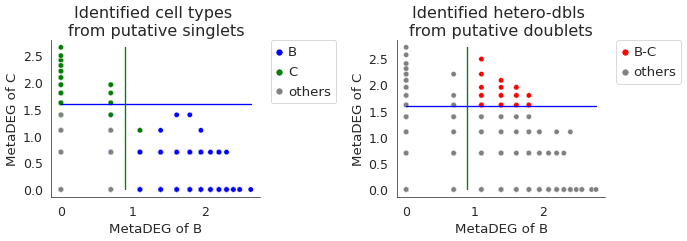

26 putative heterotypic doublets detected.
Detect doublets composed by cell type B and D.


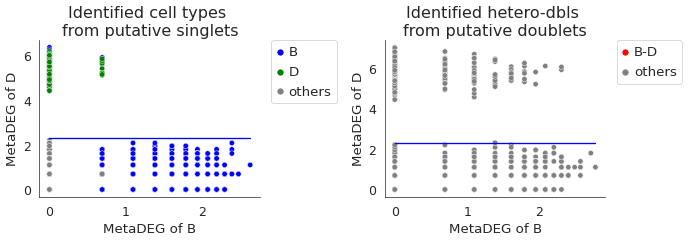

0 putative heterotypic doublets detected.
Detect doublets composed by cell type C and D.


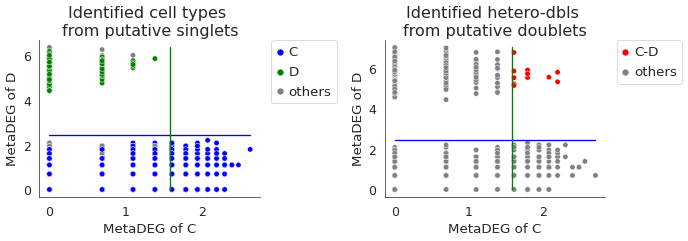

12 putative heterotypic doublets detected.


In [13]:
tm.infer.heteroDbl(adata, 
                   d_groupby = 'droplet_type', 
                   ct_groupby = 'danno_RNAonly',
                   de_sorted = degene_sorted,
                   dbl_groupby = 'heteroDbl',
                   vis=True)


The automiative detection threshold might fail in some cases, especially when outliers occur. We also provide API to mannual ajustment of the thresholds to detect heterotypic doublets, 

Below we showcase how to adjust in "A_D" and "B_D".

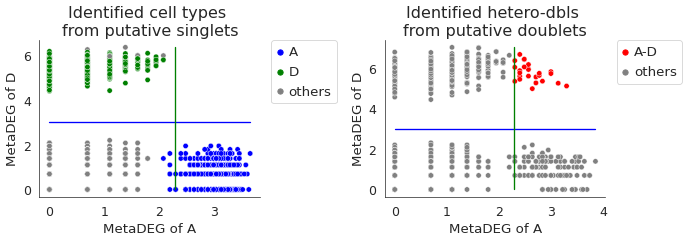

In [14]:
dbl = 'A_D'

dbl_candidate = tm.infer.heteroDbl_bc(adata, 
                                          dbl, 
                                          d_groupby = 'droplet_type', 
                                          ct_groupby = 'danno_RNAonly',
                                          threshold_y = 3,
                                          de_sorted = degene_sorted)


Then we earse the original results with automative thresholds and update

In [15]:
adata.obs.loc[adata.obs['heteroDbl']==dbl,'heteroDbl'] = 'unknown'
adata.obs.loc[dbl_candidate,'heteroDbl'] = dbl

Another example 

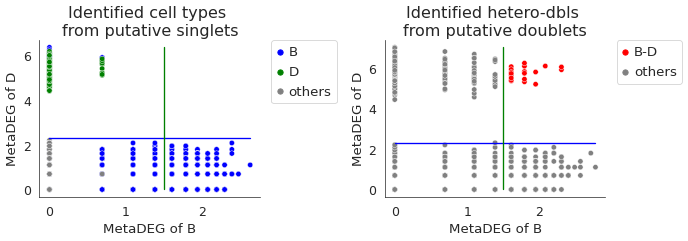

In [16]:
dbl = 'B_D'

dbl_candidate = tm.infer.heteroDbl_bc(adata, 
                                          dbl, 
                                          d_groupby = 'droplet_type', 
                                          ct_groupby = 'danno_RNAonly',
                                          threshold_x = 1.5,
                                          de_sorted = degene_sorted)

In [17]:
adata.obs.loc[adata.obs['heteroDbl']==dbl,'heteroDbl'] = 'unknown'
adata.obs.loc[dbl_candidate,'heteroDbl'] = dbl

Summary of the heterotypic doublets

In [18]:
np.unique(adata.obs['heteroDbl'], return_counts=True)

(array(['A_B', 'A_C', 'A_D', 'B_C', 'B_D', 'C_D', 'unknown'], dtype=object),
 array([  43,   12,   25,   26,   19,   12, 5935]))

## Fit signature distribution for each cell type

In [19]:
tm.fit.dmn(adata,
           groupby='danno_RNAonly',
           groups=['A','B','C','D'],
           verbose=2,
           verbose_interval = 100)

Initialization 0
Initialization 0
Initialization 0
Initialization 0
  Iteration 100	 time lapse 23.29180s	 ll change 0.01511
  Iteration 100	 time lapse 31.23770s	 ll change 0.03919
  Iteration 100	 time lapse 33.59617s	 ll change 0.07604
  Iteration 200	 time lapse 22.55147s	 ll change 0.00144
Initialization converged: True	 time lapse 50.34428s	 ll -9807.11887
A is done!
Initialization converged: True	 time lapse 51.57727s	 ll -13517.22824
B is done!
  Iteration 200	 time lapse 30.22276s	 ll change 0.00148
Initialization converged: True	 time lapse 65.64157s	 ll -37159.59384
  Iteration 200	 time lapse 32.37463s	 ll change 0.00867
D is done!
  Iteration 300	 time lapse 32.26834s	 ll change 0.00196
Initialization converged: True	 time lapse 115.43128s	 ll -25138.43835
C is done!


## Infer total-mRNA ratios

In [20]:
adata.obs['total_UMIs'] = np.ravel(adata.X.sum(1))
adata.obs['log10_totUMIs'] = np.log10(adata.obs['total_UMIs'])
tm.fit.logN_para(adata,
                 logUMIby='log10_totUMIs',
                 groupby='danno_RNAonly',
                 inplace=True)

In [21]:
adata_mgdic = tm.infer.get_dbl_mg(adata, groupby='heteroDbl')

A_B
Initialized.
Iteration 2	time lapse 6.008196830749512s	ll change 52.029150797425245

Iteration 4	time lapse 5.9948201179504395s	ll change 0.015511993333348073

Iteration 6	time lapse 5.979774236679077s	ll change 0.006479689764091745



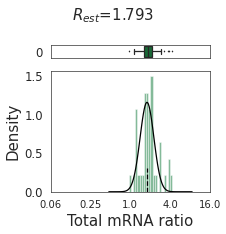

A_D
Initialized.
Iteration 2	time lapse 3.6050872802734375s	ll change 264.1966886172886

Iteration 4	time lapse 3.6045525074005127s	ll change 2.632783175773511

Iteration 6	time lapse 3.6269397735595703s	ll change 0.08591699690441601

Iteration 8	time lapse 3.6388285160064697s	ll change 0.20002352387382416

Iteration 10	time lapse 3.5962095260620117s	ll change 0.09375328723399434

Iteration 12	time lapse 3.6077051162719727s	ll change 0.0



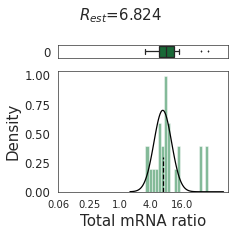

A_C
Initialized.
Iteration 2	time lapse 1.856900930404663s	ll change 9.779283135507285

Iteration 4	time lapse 1.9255235195159912s	ll change 0.0



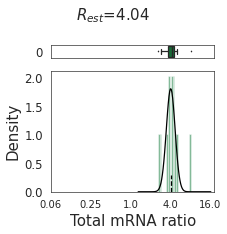

B_D
Initialized.
Iteration 2	time lapse 2.799057722091675s	ll change 85.22885253937056

Iteration 4	time lapse 2.8160691261291504s	ll change 0.06049696068657795

Iteration 6	time lapse 2.8080461025238037s	ll change 0.013397349553997628

Iteration 8	time lapse 2.7892954349517822s	ll change 0.001661282301938627



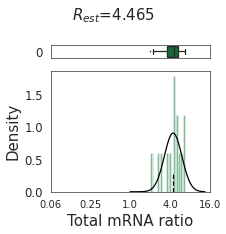

B_C
Initialized.
Iteration 2	time lapse 3.7581214904785156s	ll change 110.162315778427

Iteration 4	time lapse 3.730236768722534s	ll change 0.08773780424962752



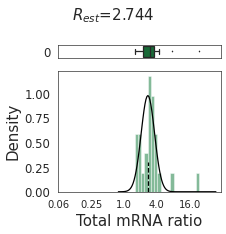

C_D
Initialized.
Iteration 2	time lapse 1.8889849185943604s	ll change 392.0540477444192

Iteration 4	time lapse 1.8992326259613037s	ll change 0.0



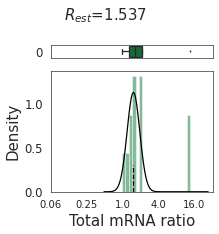

In [22]:
for dbl in adata_mgdic:
    print(dbl)
    
    tm.infer.ratios_bc(adata_mgdic[dbl],dbl,verbose=1)
    w_best = adata_mgdic[dbl].uns['ratio']['w_best']
    tm.vis.logRatio_dist((1-w_best)/w_best)

## Compare with simulation ground truth

In [23]:
dbl_groups = list(adata_mgdic.keys())

In [24]:
for i in range(len(dbl_groups)):
    
    dbl = dbl_groups[i]

    log2R_true = np.log2(adata.obs.loc[adata.obs['heteroDbl']==dbl,'trueR'])
    w_best = adata_mgdic[dbl].uns['ratio']['w_best']
    log2R_pred = np.log2((1-w_best)/w_best)
    
    trueR = 2**np.mean(tm.auxi.rm_outliers(log2R_true[~np.isnan(log2R_true)]))
    predR = 2**np.mean(tm.auxi.rm_outliers(log2R_pred))
    err = trueR - predR
    print(dbl,'true R=',trueR,', predicted R=',predR,', err=',err)

A_B true R= 1.740032658434202 , predicted R= 1.7927088986516704 , err= -0.052676240217468306
A_D true R= 6.453011210546609 , predicted R= 6.824118812872906 , err= -0.3711076023262976
A_C true R= 4.36453053893642 , predicted R= 4.0403523583923935 , err= 0.3241781805440267
B_D true R= 4.507771530493424 , predicted R= 4.464895437820999 , err= 0.04287609267242498
B_C true R= 2.9659917919117658 , predicted R= 2.744172248651441 , err= 0.22181954326032471
C_D true R= 1.6045277891932905 , predicted R= 1.5366319339591041 , err= 0.0678958552341864


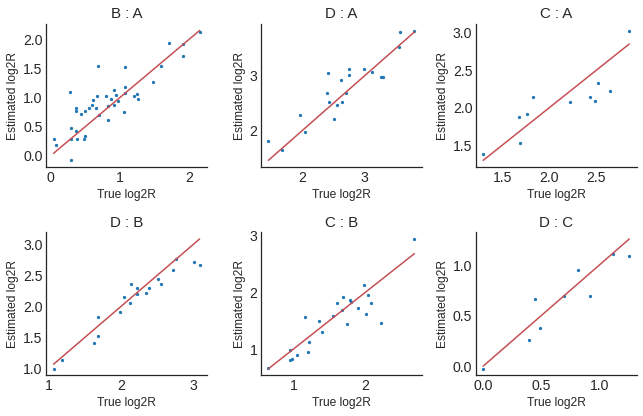

In [25]:
from matplotlib import pyplot as plt

plt.figure(figsize=(9,3*np.ceil(len(dbl_groups) / 3)), dpi=72)
plt.style.use('seaborn-white')
for i in range(len(dbl_groups)):
    ax = plt.subplot(int(np.ceil(len(dbl_groups)/3)),3,i+1)
    
    dbl = dbl_groups[i]

    log2R_true = np.log2(adata.obs.loc[adata.obs['heteroDbl']==dbl,'trueR'])
    w_best = adata_mgdic[dbl].uns['ratio']['w_best']
    log2R_pred = np.log2((1-w_best)/w_best)

    plt.scatter(log2R_true, log2R_pred,s=5)
    plt.plot([np.min(log2R_true),np.max(log2R_true)],[np.min(log2R_true),np.max(log2R_true)],c='r')

    plt.xlabel('True log2R',fontsize=12)
    plt.ylabel('Estimated log2R',fontsize=12)
    plt.title(dbl.split('_')[1]+' : '+dbl.split('_')[0],fontsize=15)

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')

#plt.suptitle('DB: '+str(dataplot.shape[1])+' ADTs,'+str(dataplot.shape[0])+' droplets',fontsize=15)    
plt.subplots_adjust(top=0.9, bottom=0.1, left=0.1, right=0.9, hspace=0.6,wspace=0.15)
plt.tight_layout()
plt.show()

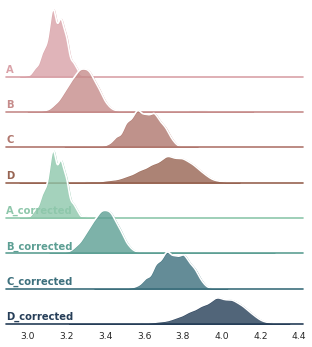

In [26]:
tm.vis.corrected_UMI_hist(adata,
                          groupby = 'danno_RNAonly',
                          groups = ['A','B','C','D'],
                          reference = 'A',
                          logUMIby = 'log10_totUMIs',
                          ratios = [1,1.8,4,6.7])